<a href="https://colab.research.google.com/github/lupries/TAGN2/blob/master/scripts/TrainDavisSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAVIS Segmentation (training script)
## 1. Get dataloader and training scripts

In [0]:
!git clone https://github.com/lupries/TAGN2.git
!cd TAGN2 && git pull

In [0]:
from TAGN2 import train_model, show_results
from TAGN2.datasets import SegDataset, create_dataloader

## 2. Get dataset

In [0]:
!git clone https://github.com/davisvideochallenge/davis-2017.git
%cd davis-2017/data
!ls && ./get_davis.sh
%cd ../../

## 3. Load DeepLabV3 model

In [0]:
import torch
from torchvision import models
from sklearn.metrics import f1_score
import numpy as np

model = models.segmentation.deeplabv3_resnet101(pretrained = True)
model.classifier = models.segmentation.deeplabv3.DeepLabHead(2048, num_classes=1) 

## 4. Train model

In [0]:
root = 'davis-2017/data/'
dataloader = create_dataloader(root, 'DAVIS/JPEGImages/480p/','DAVIS/Annotations/480p/', size=(512,256),batch_size=4, subset='train')
#model = trained_model
#criterion = torch.nn.MSELoss(reduction='mean')
criterion = torch.nn.BCEWithLogitsLoss(weight=torch.tensor([12]).to("cuda:0"))
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0005)
metrics = {'f1_score': f1_score}
trained_model = train_model(model, criterion, dataloader, optimizer,metrics=metrics, num_epochs = 1)
torch.save(trained_model.state_dict(),'drive/My Drive/models/model_256_1e-4_9e-1_5e-4_SGD_1.pt')
trained_model = train_model(trained_model, criterion, dataloader, optimizer,metrics=metrics, num_epochs = 1)
torch.save(trained_model.state_dict(),'drive/My Drive/models/model_256_1e-4_9e-1_5e-4_SGD_2.pt')
trained_model = train_model(trained_model, criterion, dataloader, optimizer,metrics=metrics, num_epochs = 1)
torch.save(trained_model.state_dict(),'drive/My Drive/models/model_256_1e-4_9e-1_5e-4_SGD_3.pt')
#trained_model = train_model(trained_model, criterion, dataloader, optimizer,metrics=metrics, num_epochs = 1)
#torch.save(trained_model.state_dict(),'drive/My Drive/models/model_480_BCEWL_4.pt')

## 5. Plot training curves (loss & accuracy)

In [0]:
%load_ext tensorboard
%tensorboard --logdir runs

## 6. Visualize results

['blackswan', 'bmx-trees', 'breakdance', 'camel', 'car-roundabout', 'car-shadow', 'cows', 'dance-twirl', 'dog', 'drift-chicane', 'drift-straight', 'goat', 'horsejump-high', 'kite-surf', 'libby', 'motocross-jump', 'paragliding-launch', 'parkour', 'scooter-black', 'soapbox']
9.508129 -8.183823
1.0 0.0
(3, 480, 854) (480, 854) (480, 854)


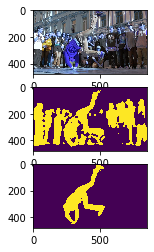

9.443945 -7.886098
1.0 0.0
(3, 480, 854) (480, 854) (480, 854)


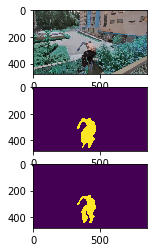

9.354769 -8.860551
1.0 0.0
(3, 480, 854) (480, 854) (480, 854)


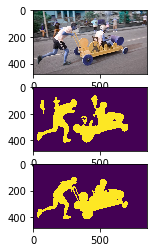

7.796383 -8.7980385
1.0 0.0
(3, 480, 854) (480, 854) (480, 854)


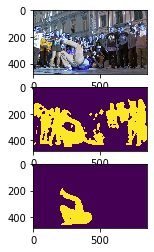

8.36665 -8.39148
1.0 0.0
(3, 480, 854) (480, 854) (480, 854)


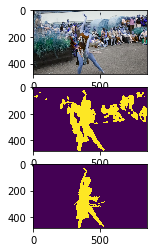

7.3154316 -8.22008
1.0 0.0
(3, 480, 854) (480, 854) (480, 854)


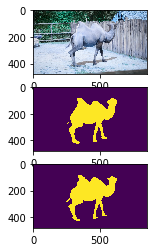

5.8722143 -7.4418635
1.0 0.0
(3, 480, 854) (480, 854) (480, 854)


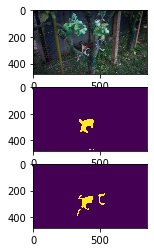

8.479722 -8.185403
1.0 0.0
(3, 480, 854) (480, 854) (480, 854)


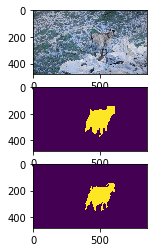

8.359787 -8.392139
1.0 0.0
(3, 480, 854) (480, 854) (480, 854)


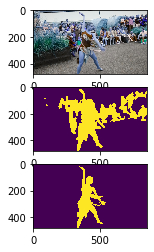

7.823204 -7.61972
1.0 0.0
(3, 480, 854) (480, 854) (480, 854)


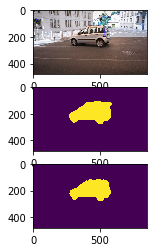

8.497471 -6.817624
1.0 0.0
(3, 480, 854) (480, 854) (480, 854)


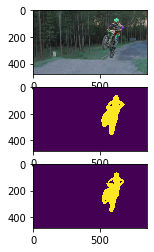

8.181723 -7.0739202
1.0 0.0
(3, 480, 854) (480, 854) (480, 854)


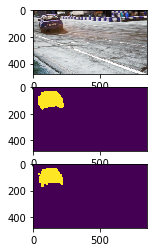

In [7]:
trained_model = model.to("cuda:0")
root = 'davis-2017/data/'
dataloader = create_dataloader(root, 'DAVIS/JPEGImages/480p/','DAVIS/Annotations/480p/', size=(854,480),batch_size=3, subset='val')
show_results(trained_model, dataloader, 12)

## 6. Load & Save model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
model.load_state_dict(torch.load('drive/My Drive/models/model_256_1e-4_9e-1_5e-4_SGD_3.pt'))

<All keys matched successfully>

In [0]:
torch.save(trained_model.state_dict(),'drive/My Drive/models/model_256_BCEWL_1.pt')

## 7. Generate masks

In [0]:
import yaml
import glob
import os
import numpy as np
import torch
import cv2
from TAGN2.datasets.dataloader import Resize, ToTensor, Normalize
from torchvision import transforms

def generate_masks(model, root_dir, target_dir, imageFolder, img_size):
  model.eval()
  info_file = open(root_dir+'db_info.yaml', 'r')
  seq_list = yaml.load(info_file)['sequences']
  transformation = transforms.Compose([Resize(img_size,img_size), ToTensor(), Normalize()])
  for seq in seq_list:
    if seq['year'] == 2016 and seq['set'] == 'val':
      seq_name = seq['name']
      #os.mkdir(os.path.join(target_dir, seq_name))
      image_names = sorted(os.listdir(os.path.join(root_dir, imageFolder, seq_name)))
      for img in image_names:
        image_path = os.path.join(root_dir, imageFolder, seq_name, img)
        image = cv2.imread(image_path, 1).transpose(2, 0, 1)
        image_dict = {'image': image, 'mask': image}
        image_dict = transformation(image_dict)
        input_img = image_dict['image'].reshape((1,)+image_dict['image'].shape).to("cuda:0")
        with torch.set_grad_enabled(False):
          output = model(input_img)
          print(output)
          mask = 1.0/(1.0+np.exp(-output['out'].data.cpu().numpy()))
          mask_img = mask[0]
          retransform = Resize((854,480),(854,480))
          mask_img = retransform({'image': mask_img, 'mask': mask_img})
          mask_img = np.asarray(mask_img['image']>0.5, dtype=np.uint8)
          img_png = img[:-4]+'.png'
          #os.remove(os.path.join(target_dir, seq_name, img))
        cv2.imwrite(os.path.join(target_dir, seq_name, img_png), mask_img)

root = 'davis-2017/data/'
generate_masks(model, root, 'drive/My Drive/masks/model_256_3', 'DAVIS/JPEGImages/480p/', (512,256))

In [17]:
import shutil
shutil.move("runs","drive/My Drive/runs2")

'drive/My Drive/runs2'